# AIN313 Assignment 3


### By Adam Sattout, b2220765061

# Part 1: Throery Questions

#### Question 1

##### What are activation functions, and why are they important in neural networks?



Activation functions are mathematical functions used in neural networks to introduce non-linearity into the network. These functions are applied to the output of each neuron in the network to determine whether the neuron should be activated or not, based on the weighted sum of its inputs. Some examples may be RELU, Sigmoid, and Tanh. As mentioned before, these functions provide non-linearity to the network, enabling it to recognize non-linear data. While if not introduced, all the neurons will be a simple linear combination of its inputs and weights

#### Question 2
Consider the convolutional neural network defined by the layers below. Fill in the shape
of the output volume and the number of parameters at each layer.

• CONV5-8: Convolutional layer with 8 filters of 5 ×5, padding is 0, stride is 1.

• POOL-2: 2 ×2 max-pooling layer, stride is 2.

• CONV3-16: Convolutional layer with 16 filters of 3 ×3, padding is 0, stride is 1.

• POOL-3: 3 ×3 max-pooling layer, stride is 2.

• FC-30: Fully connected layer with 30 neurons.

• FC-5: Fully connected layer with 5 neurons.

• Input: 64 ×64 ×3

#### Solution for Question 2

| Layer | Output Volume Shape | Number of Parameters |
|----------|----------|----------|
| Input  | (64, 64, 3)  | 0  |
| CONV5-8  | (60, 60, 8)  | 608  |
| POOL-2  | (30, 30, 8) | 0  |
| CONV3-16  | (28, 28, 16) | 1168  |
| POOL-3  | (13, 13, 16) | 0  |
| FC-30  | (30, ) | 81150  |
| FC-5  | (5, ) | 155  |

# Part 2: Classification of Skin Lesion Images using Neural Network

In [1]:
#Importing necessary libraries

import pandas as pd
from IPython.display import Markdown, display
import torch
import torch_directml
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [20]:
#Creating a refrence for our GPU and preparing transformers that normalize and resize the image when needed

dml = torch_directml.device(torch_directml.default_device())

transformer = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])         # Convert PIL images to PyTorch tensors
])

resizeTransformer = transforms.Compose([
    transforms.Resize((50, 50)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

#### Example batch

In [21]:
batch_size = 16
classes = ["benign", "malignant"]

In [22]:
dataset = datasets.ImageFolder(root='311PA3_melanoma_dataset/train', transform=transformer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(dataset.class_to_idx)

{'benign': 0, 'malignant': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


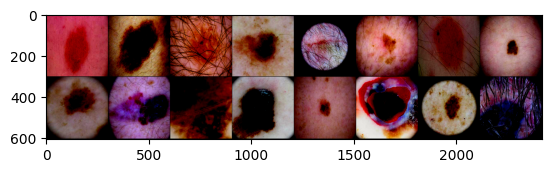

benign benign benign malignant malignant benign benign benign malignant malignant malignant malignant malignant malignant malignant malignant


In [29]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

This is how we will create samples for our model to learn, we can also see how normalized images look and what they are labeled as.

#### Creating Necessary Functions

In [7]:
# Basic function to print model metrics after training

def print_metrics(y_pred, y_true):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.2f}")

    # Precision
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {precision:.2f}")

    # Recall
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {recall:.2f}")

    # F1
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"F1 Score: {f1:.2f}\n")

    return [round(acc, 3) ,round(float(precision), 3), round(float(recall), 3), round(float(f1), 3)]

In [8]:
#In this cell we specify the structure of both our MLP and CNN, while giving the choice 
#of the activation function while instantiating

import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, activation, n_in):
        super().__init__()
        self.fc1 = nn.Linear(n_in * n_in * 3, 128) #wX + b
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
        self.activation = F.sigmoid # 1/1 + e ^ (-x)
        if activation == "Relu":
            self.activation = F.relu # max(0, x)
            

    def forward(self, x):
        x = torch.flatten(x, 1) #flatten image 2d vector into 1d
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = F.sigmoid(self.fc3(x))

        return x


class CNN(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 9, 3) # Applies filter acrross the pixels of the image
        self.pool = nn.MaxPool2d(2, 2) # Takes max value of 2x2 spaces in image
        self.conv2 = nn.Conv2d(16, 8, 5, 2, 1)
        self.fc1 = nn.Linear(12 * 12 * 8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        if activation == "Sigmoid":
            self.activation = F.sigmoid
        elif activation == "Relu":
            self.activation = F.relu
            

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = F.sigmoid(self.fc3(x))

        return x

In [9]:
#A simple function that sets the threshold of logits in last layer

def threshold_to_binary(float_list, threshold):
    return [1 if value >= threshold else 0 for value in float_list]

In [10]:
#This function takes a model and tests it, based on error value (1 or 0)
#it either returns the loss of the model or prints metrics of the model

def testModel(model, error, transform):
    model.eval()

    preds = []
    processedLabels = []

    #Prepare data loader and criterion, then empty cache to keep space for GPU memory
    test = datasets.ImageFolder(root='311PA3_melanoma_dataset/test', transform=transform)
    testLoader = DataLoader(test, batch_size=1)

    criterion = nn.BCEWithLogitsLoss()

    torch.cuda.empty_cache()

    testError = 0.0

    for i, data in enumerate(testLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # forward + getting loss
        with torch.no_grad():
            outputs = model(inputs.to(dml))
        outputs = outputs.squeeze(dim=-1) 
        loss = criterion(outputs, labels.float().to(dml))
        testError += loss.item()
        
        preds.append(outputs.item())

        del outputs

        processedLabels.append(labels.item())


    #Based on error variable, return values
    
    if error:
        return testError/len(testLoader)
    
    threshold = 0.5
    binary_list = threshold_to_binary(preds, threshold)
    return print_metrics(binary_list, processedLabels)
    

In [11]:
#This is the main training funcation, it takes the model and the different
#parameters and trains the model based on them

def train(model, lr, batch_size, transformer, num_epochs):
    print("Training..")

    #Prepare data loader
    dataset = datasets.ImageFolder(root='311PA3_melanoma_dataset/train', transform=transformer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    #Set up our optimizer with chosen learning rate and criterion
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    #Lists for plotting loss graphs
    trainLossi = []
    testLossi = []
    lossi = []
    indexi = []

    step = 0

    for epoch in range(num_epochs):  # loop over the dataset for n epochs
        model.train()
        running_loss = 0.0
        cycleLoss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.to(dml))
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels.float().to(dml))
            loss.backward()
            optimizer.step()

            del inputs
            del labels
            #Update plot values

            running_loss += loss.item()
            cycleLoss += loss.item()

            step += 1
            if i % 5 == 4:
                lossi.append(cycleLoss / 5)
                indexi.append(step)
                cycleLoss = 0.0
        trainLossi.append(running_loss/len(dataloader))
        testLossi.append(testModel(model, True, transformer))
        print("█▄", end = "")

    #Return plot values after model is trained
    print('\nFinished Training')
    return [indexi, lossi, trainLossi, testLossi]

In [12]:
#These are simple functions for 

def plotTrainTestError(num_epochs, trainLoss, testLoss):
    plt.figure(figsize=(12, 8))  # Width: 10 inches, Height: 6 inches


    plt.plot(range(num_epochs), trainLoss, label='Train Error', color='blue', linestyle='--')
    plt.plot(range(num_epochs), testLoss, label='Test Error', color='red', linestyle='-')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Train vs Test Error')
    plt.legend()  # Display the legend

    # Show the plot
    plt.show()

def plotTrainError(index, loss):
    plt.figure(figsize=(12, 8))

    plt.plot(index, loss)
    plt.title("Loss VS Time Through All Epochs")

### Modelling MLPS:

Note: If openned through VSCode, Markdowns should be displayed above each plot showing which attributes are related to which plots. Other IDEs might not show this but referring to the table with all models is sufficient. (1st model refers to 1st plot etc..)


## Modeling



### Model Attributes:
- Learning Rate: 0.02
- Input Size: 50
- Activation Function: Sigmoid
- Batch Size: 16
                

Training..


d:\Anaconda2\Lib\site-packages\torch\nn\functional.py:3244: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)


█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[945  55]
 [331 590]]
Accuracy: 0.80
Precision: 0.82
Recall: 0.80
F1 Score: 0.79




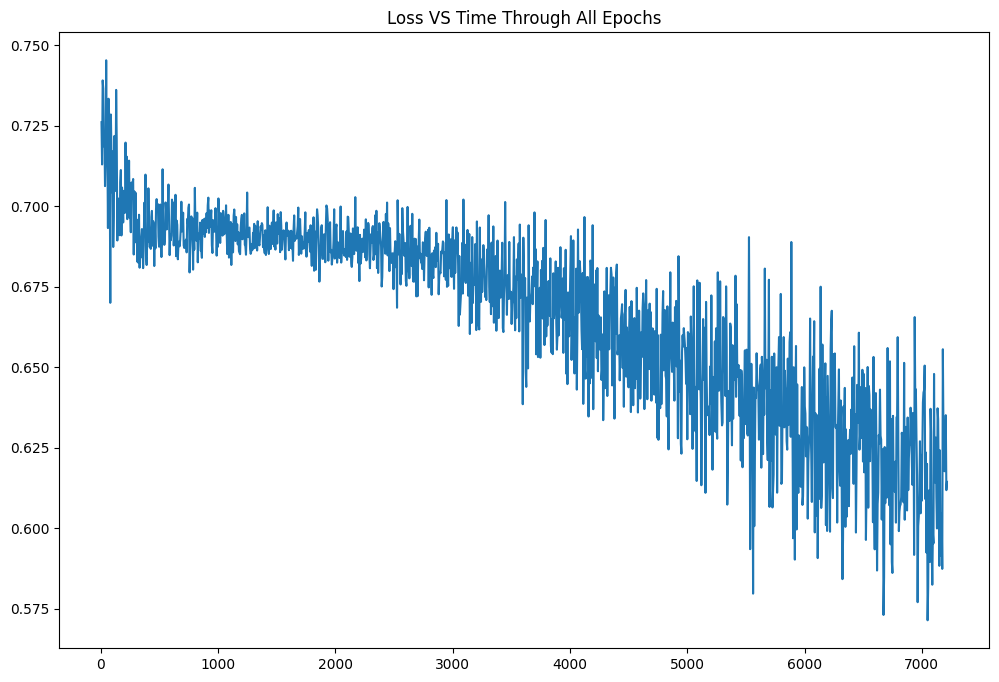

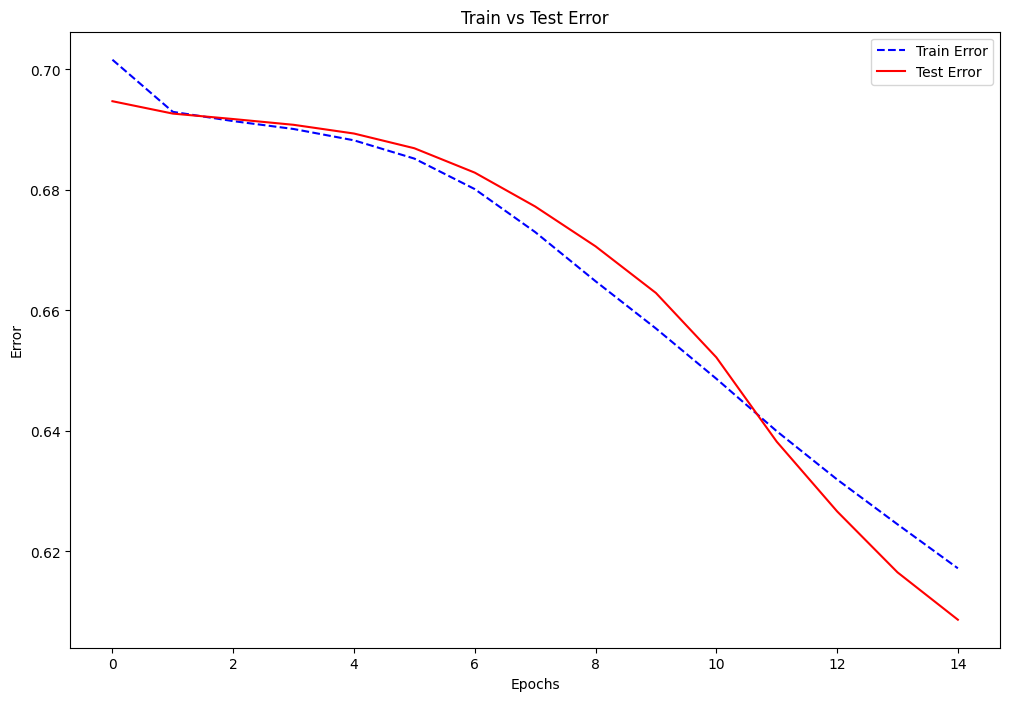


### Model Attributes:
- Learning Rate: 0.02
- Input Size: 50
- Activation Function: Relu
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[962  38]
 [242 679]]
Accuracy: 0.85
Precision: 0.87
Recall: 0.85
F1 Score: 0.85




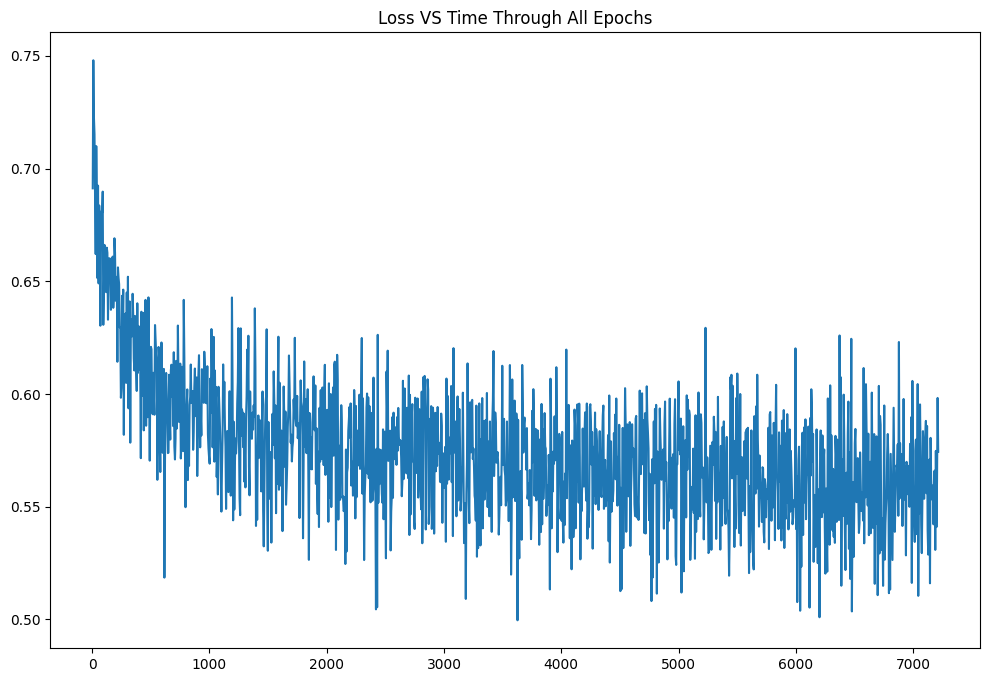

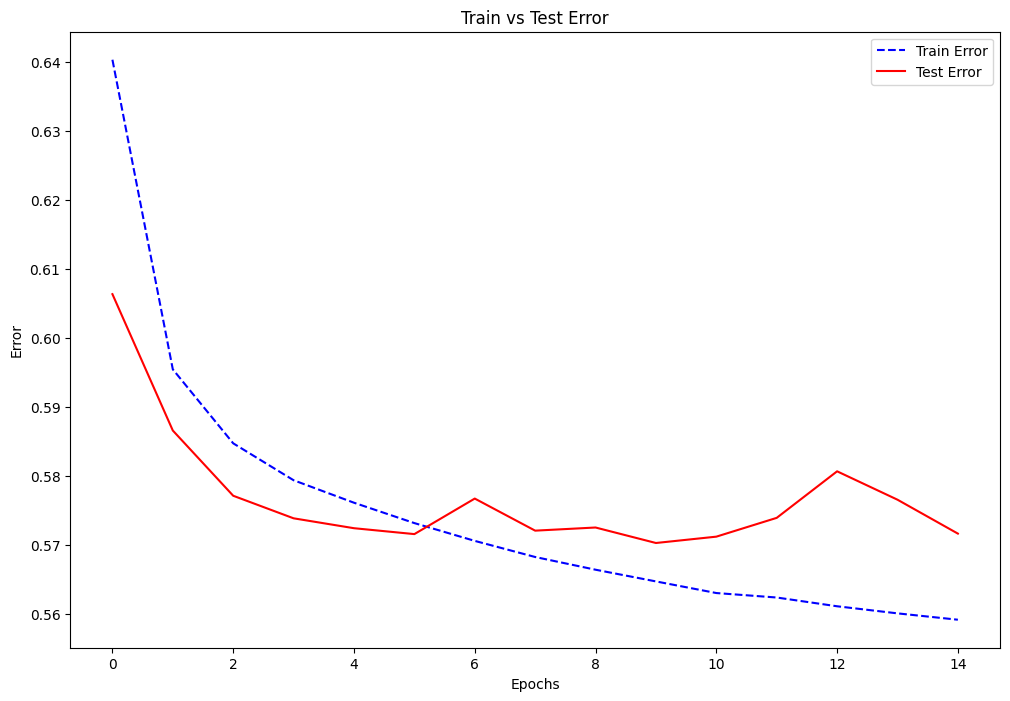


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 50
- Activation Function: Sigmoid
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[1000    0]
 [ 921    0]]
Accuracy: 0.52
Precision: 0.27
Recall: 0.52
F1 Score: 0.36




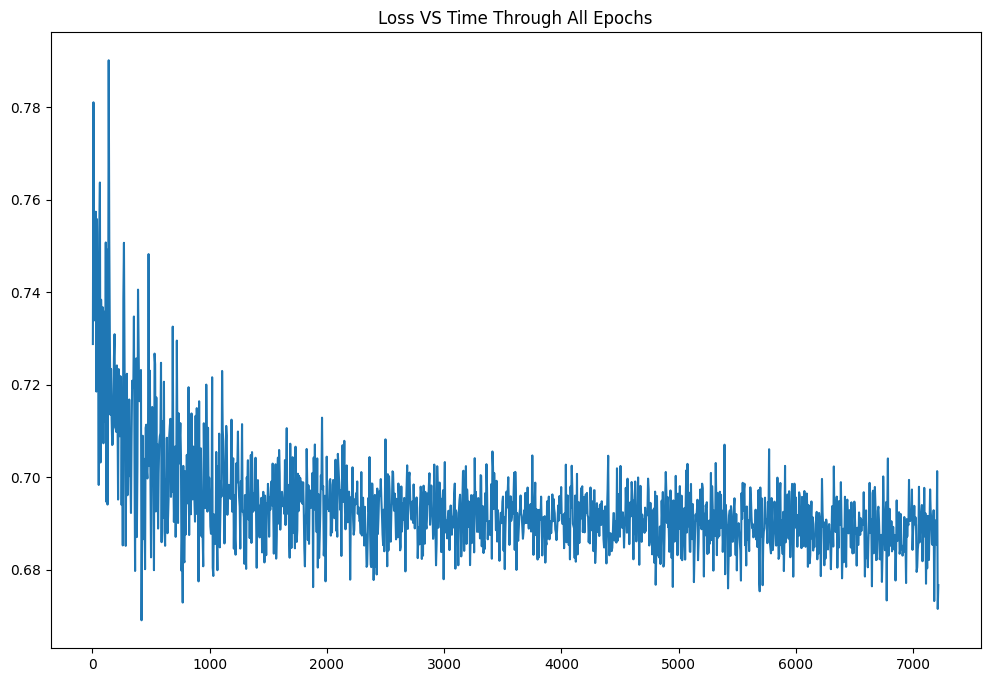

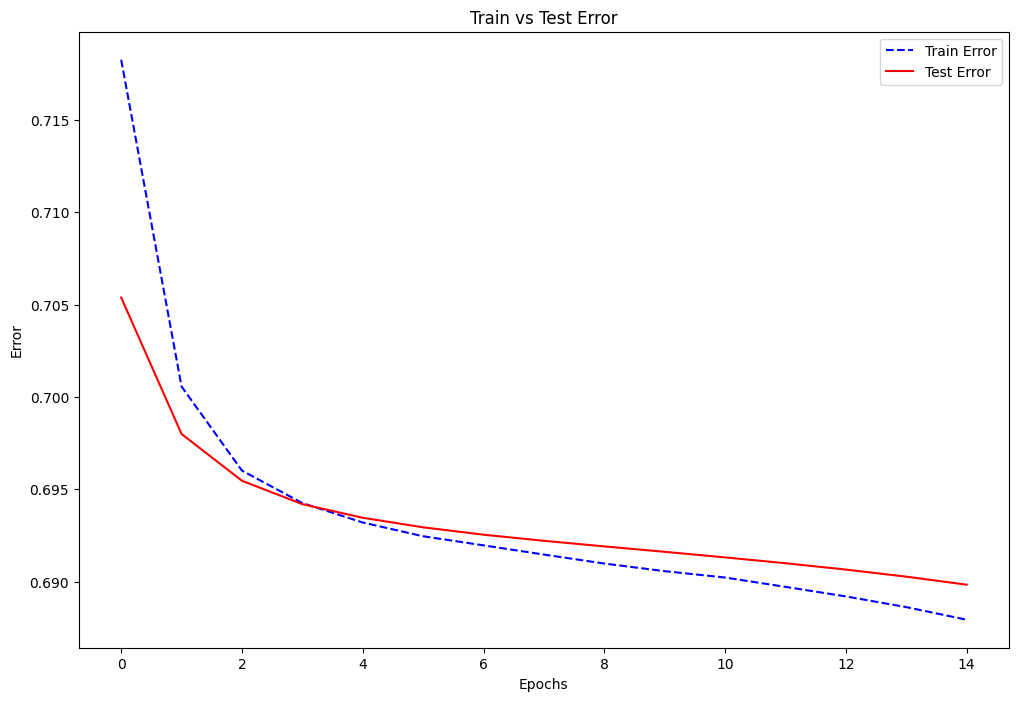


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 50
- Activation Function: Relu
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[955  45]
 [222 699]]
Accuracy: 0.86
Precision: 0.87
Recall: 0.86
F1 Score: 0.86




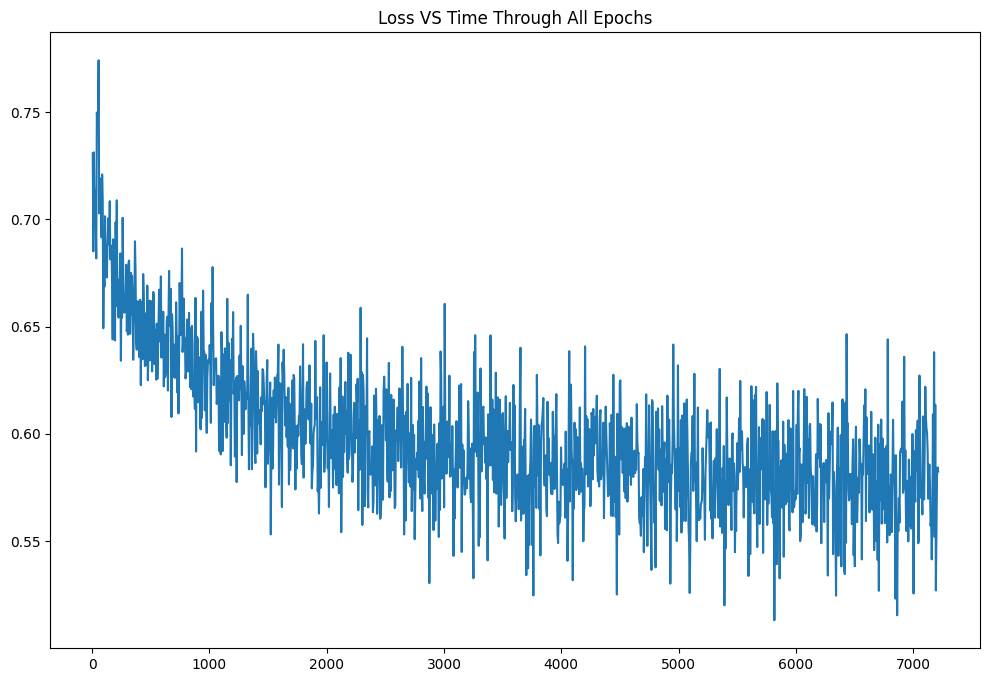

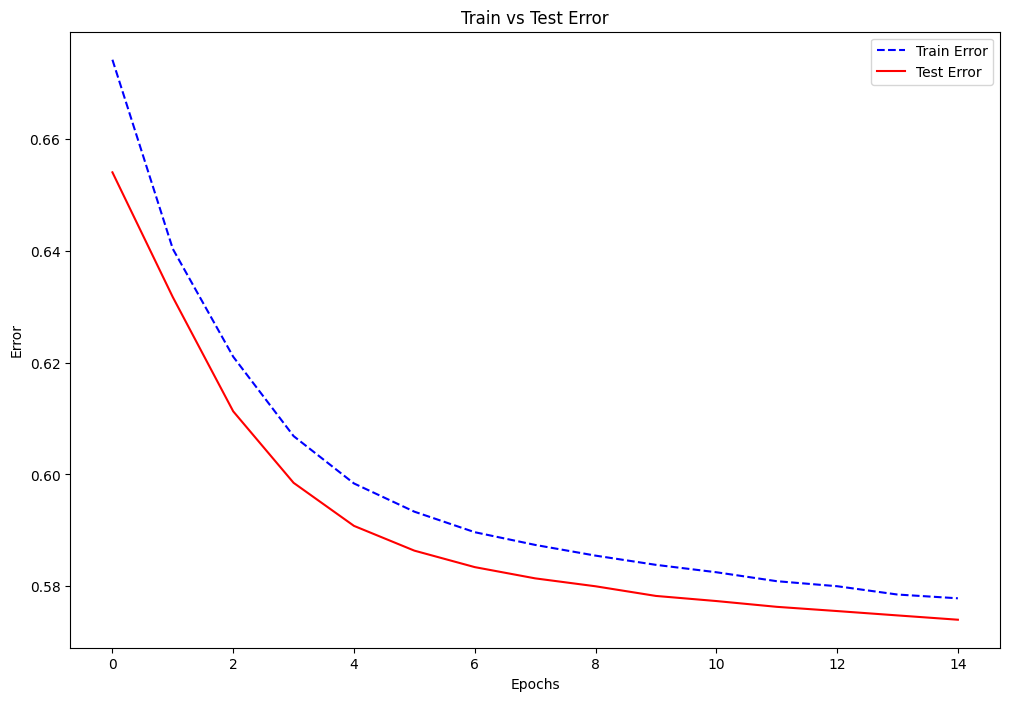


### Model Attributes:
- Learning Rate: 0.02
- Input Size: 300
- Activation Function: Sigmoid
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[913  87]
 [207 714]]
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85




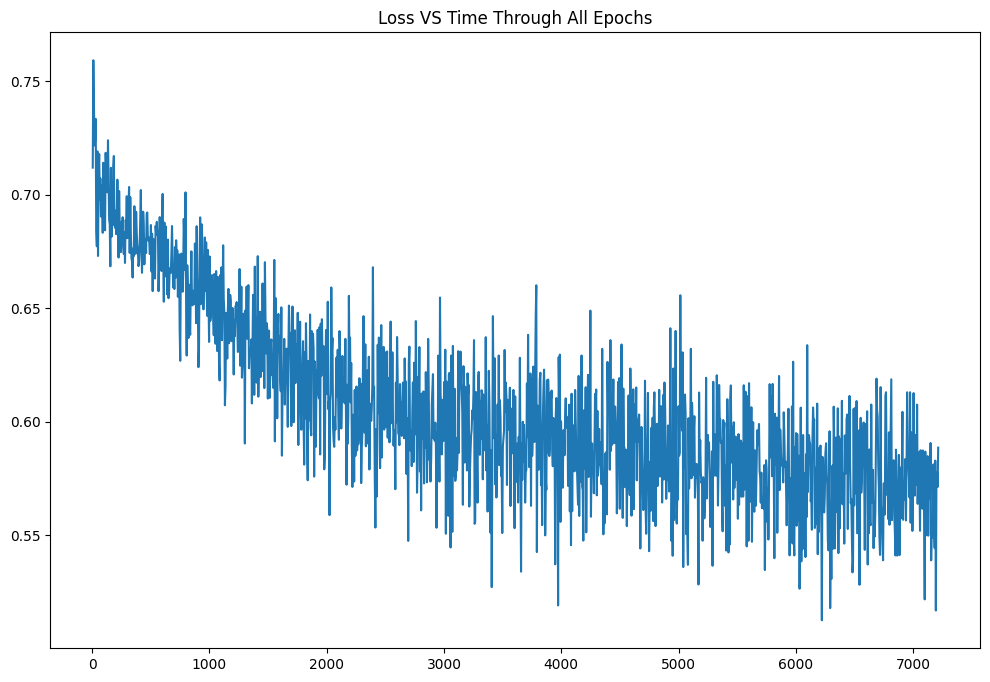

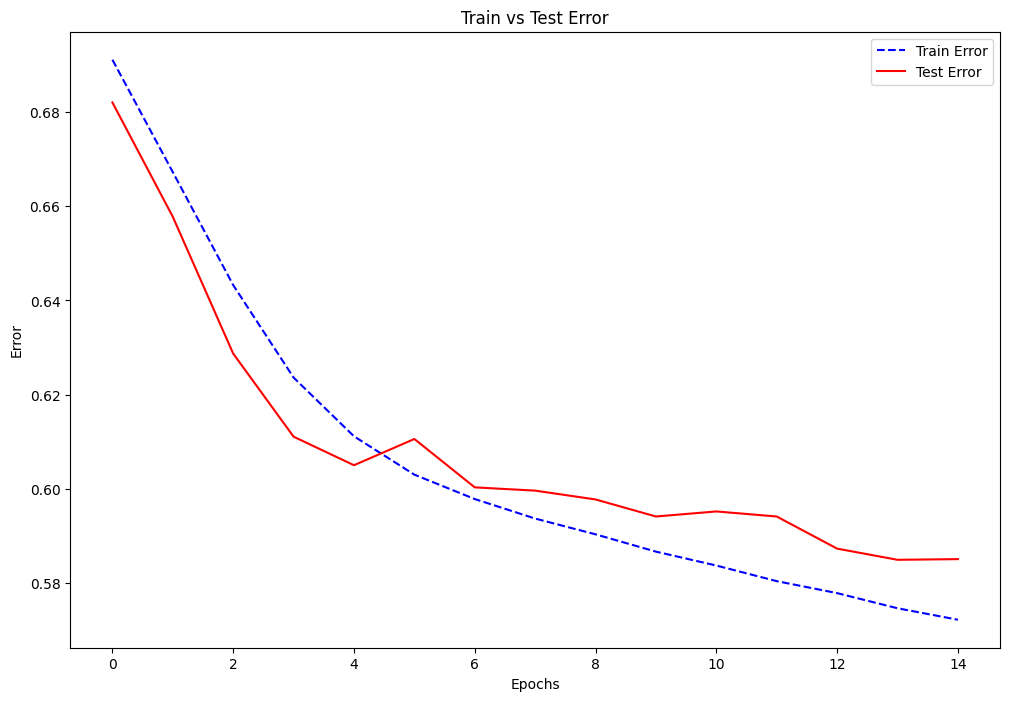


### Model Attributes:
- Learning Rate: 0.02
- Input Size: 300
- Activation Function: Relu
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[939  61]
 [119 802]]
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1 Score: 0.91




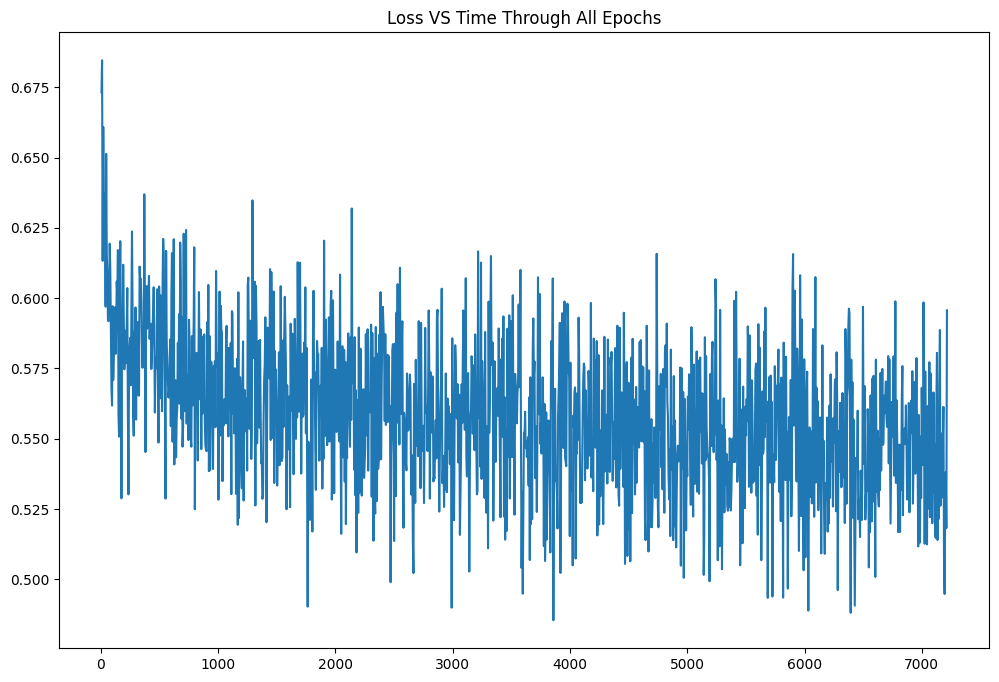

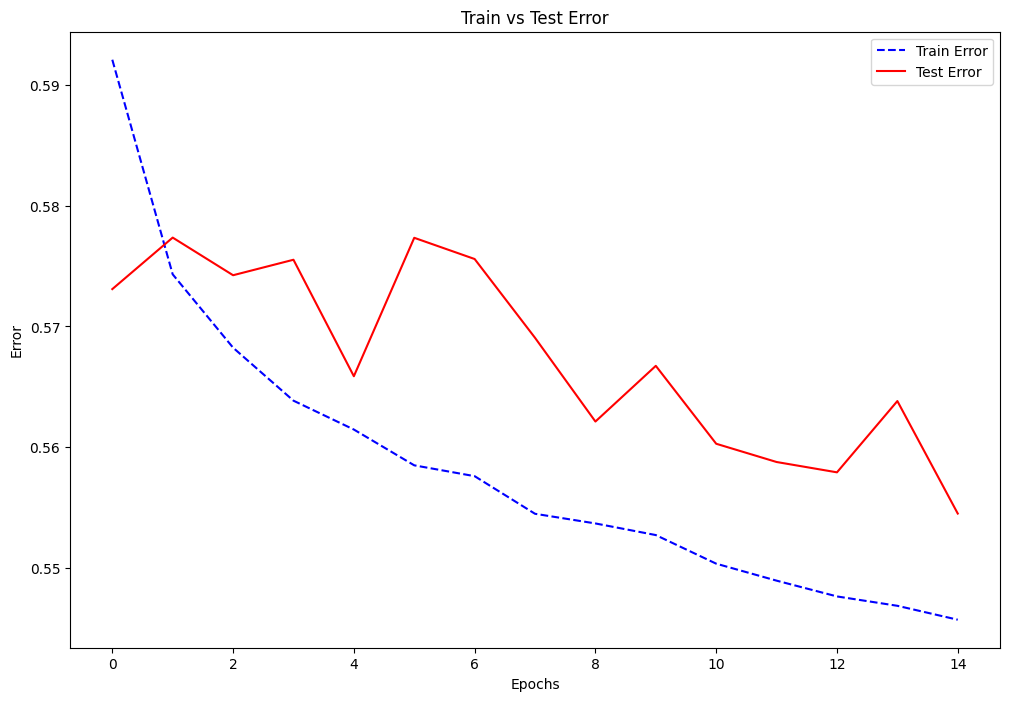


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 300
- Activation Function: Sigmoid
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[958  42]
 [412 509]]
Accuracy: 0.76
Precision: 0.81
Recall: 0.76
F1 Score: 0.75




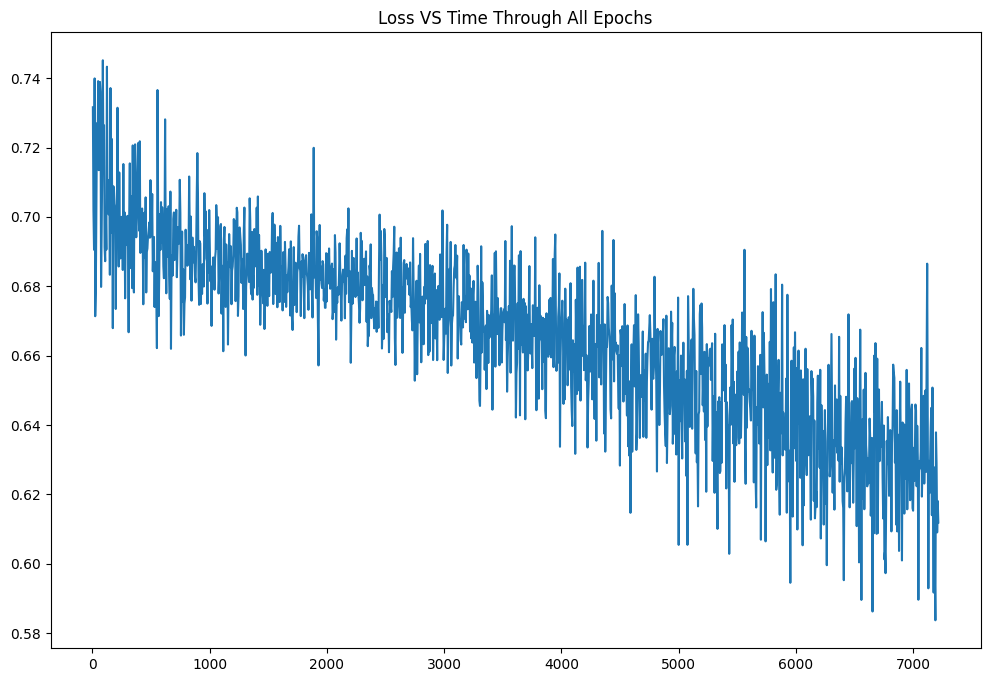

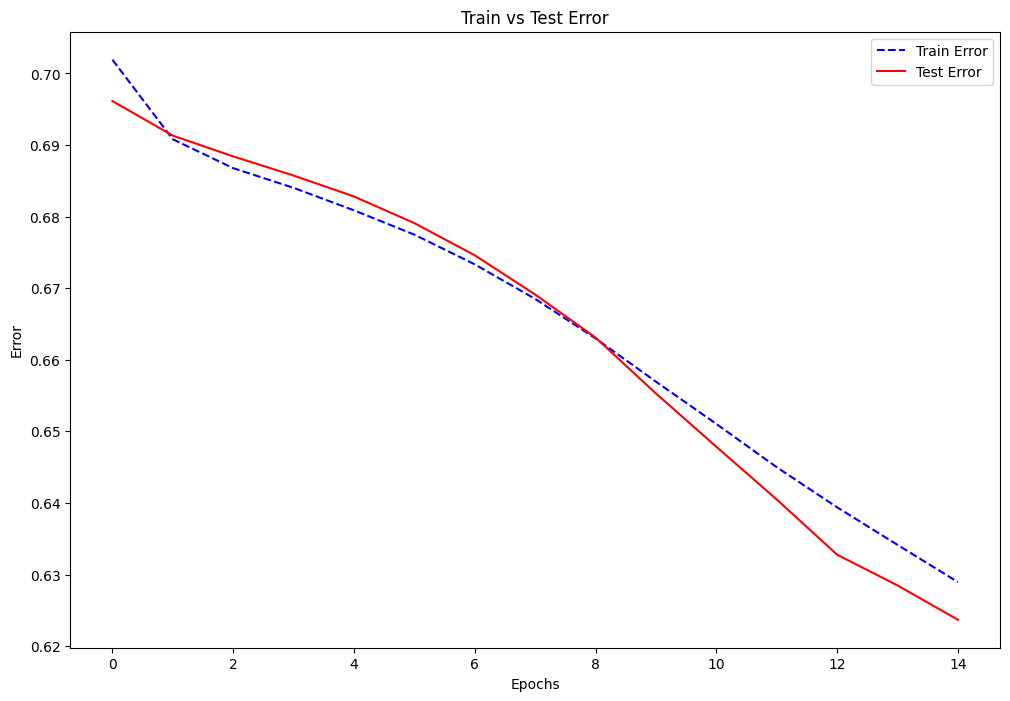


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 300
- Activation Function: Relu
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[938  62]
 [163 758]]
Accuracy: 0.88
Precision: 0.89
Recall: 0.88
F1 Score: 0.88




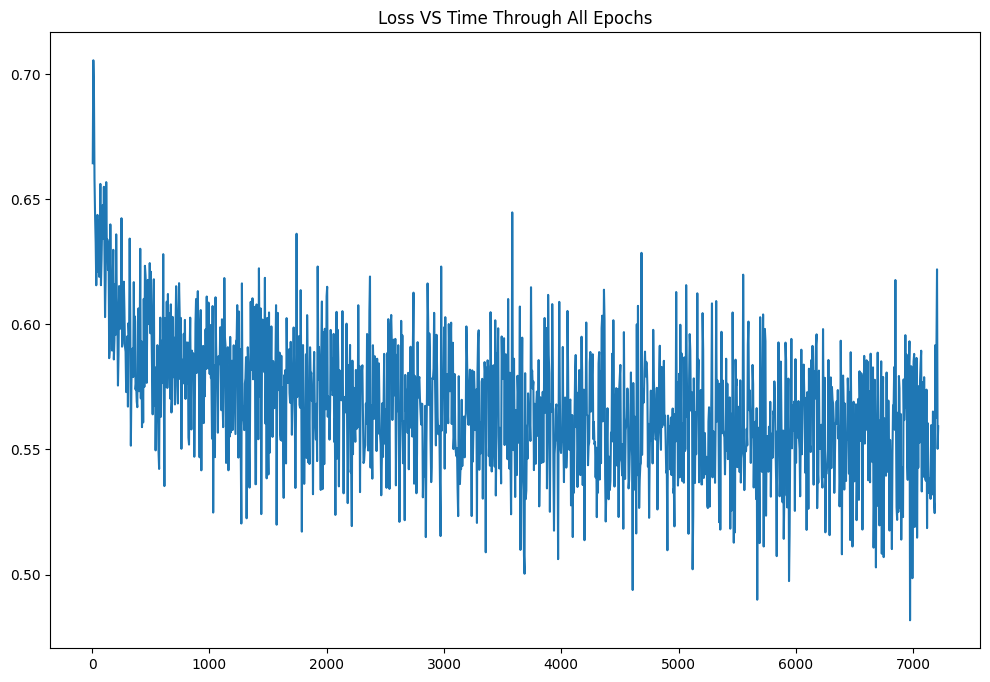

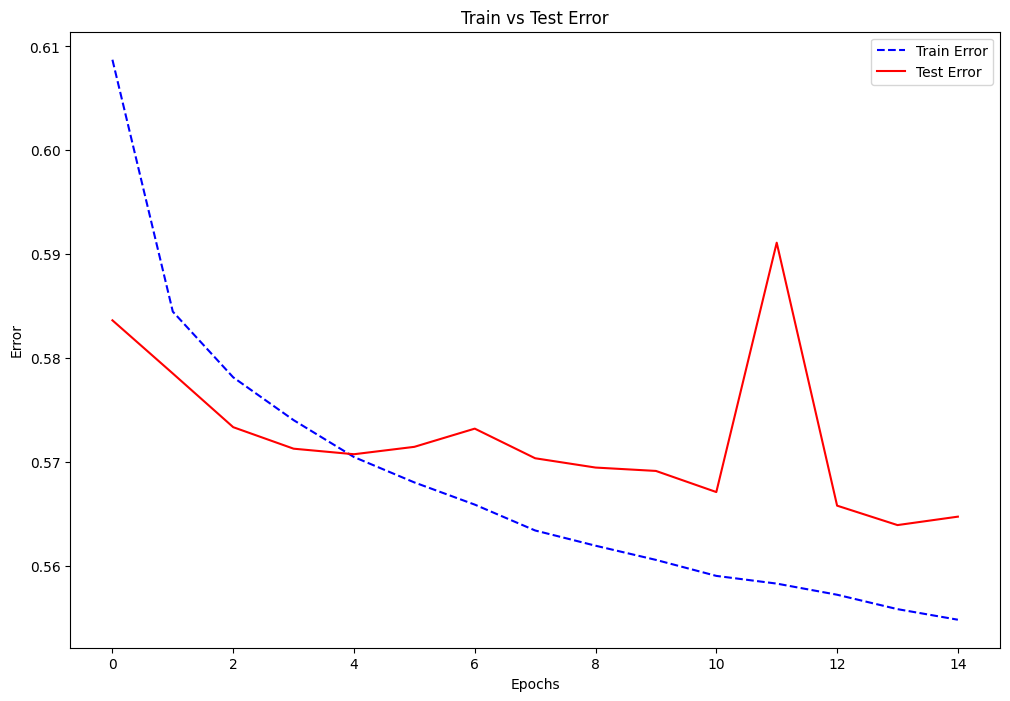

In [13]:
#This is how our models will be created, we have for loops to 
#create all 8 MLP expirements, train their models, test them, and plot
#relevant plots

text = """
## Modeling
"""
display(Markdown(text))

batch_size = 16
epoch_num = 15
i = -1

MLPModels = []

for inputSize in [50, 300]:
    for lr in [0.02, 0.005]:
        for activation in ["Sigmoid", "Relu"]:
            text = f"""
### Model Attributes:
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
                """
            display(Markdown(text))

            model = MLP(activation, inputSize).to(dml)

            if inputSize == 50:
                transform = resizeTransformer
            else:
                transform = transformer

            metrics = train(model, lr, batch_size, transform, epoch_num)

            text = """### Results: """
            display(Markdown(text))

            finalMetrics = testModel(model, False, transform)
            plotTrainError(metrics[0], metrics[1])
            print()
            plotTrainTestError(epoch_num, metrics[2], metrics[3])

            i += 1
            torch.save(model.state_dict(), f"MLPModels/model{i}.pth")

            modelDetails = ["MLP", batch_size, inputSize, lr, activation]
            modelDetails.extend(finalMetrics)
            MLPModels.append(modelDetails)

In [14]:
columns = ["Model","Batch Size", "Input Size", "Learning Rate", "Activation Function", "Accuracy", "Precision", "Recall", "F1Svore"]
df = pd.DataFrame(MLPModels, columns=columns)
df

,Model,Batch Size,Input Size,Learning Rate,Activation Function,Accuracy,Precision,Recall,F1Svore
0,MLP,16,50,0.020,Sigmoid,0.799,0.824,0.799,0.794
1,MLP,16,50,0.020,Relu,0.854,0.870,0.854,0.852
2,MLP,16,50,0.005,Sigmoid,0.521,0.271,0.521,0.356
3,MLP,16,50,0.005,Relu,0.861,0.873,0.861,0.859
4,MLP,16,300,0.020,Sigmoid,0.847,0.852,0.847,0.846
5,MLP,16,300,0.020,Relu,0.906,0.908,0.906,0.906
6,MLP,16,300,0.005,Sigmoid,0.764,0.807,0.764,0.752
7,MLP,16,300,0.005,Relu,0.883,0.887,0.883,0.882


We can see all our experiments results and plots above, and we can make comparisons of 4v4 models for each feature we are testing

#### Input Size

We can observe that MLP models scored better across all other hyperparameters when input size was set to 300 rather than 50, which makes sense since our model is gaining more input when getting a higher resolution image

#### Activation Function

There is also a clear winner here. Relu is generally a better activation function than Sigmoid. It is easy to compute and doesn't get saturated with higher weights and biases, so seeing the problem of vanishing gradient shown in plots regarding model 2 isn't surprising. The plot shows that loss just stops decreasing very early on at 0.7 loss

#### Learning Rate

In general, the higher learning rate of 0.02 performed better than 0.05, this is porbably due to 0.02 not being as high of a learning rate that would cause high instability, while also getting to the desired model faster than 0.005 learning rate. However, we can see that 0.02 models are usually close to overfitting, while 0.005 still have a margin to be trained without overfitting

At the end we can see and conduct that the best model is model 5, having lr = 0.02, inputSize = 300, and activation = Relu 

### Modeling CNNS:


## Modeling



### Model Attributes:
- Learning Rate: 0.02
- Input Size: 300
- Activation Function: Sigmoid
- Batch Size: 16
                

Training..


d:\Anaconda2\Lib\site-packages\torch\nn\functional.py:3244: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)


█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[1000    0]
 [ 921    0]]
Accuracy: 0.52
Precision: 0.27
Recall: 0.52
F1 Score: 0.36




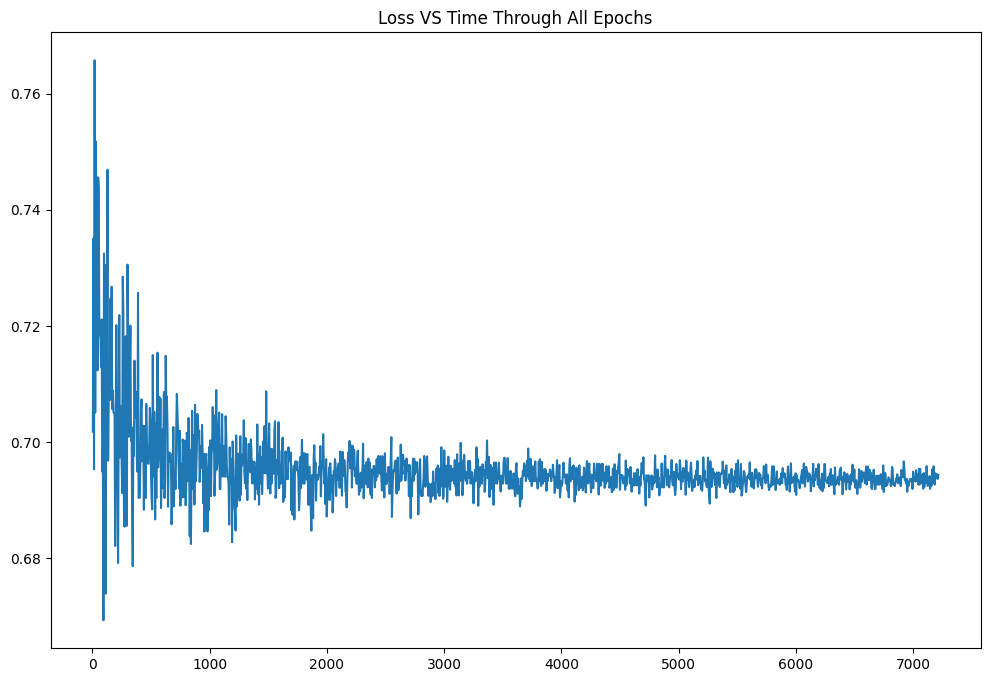

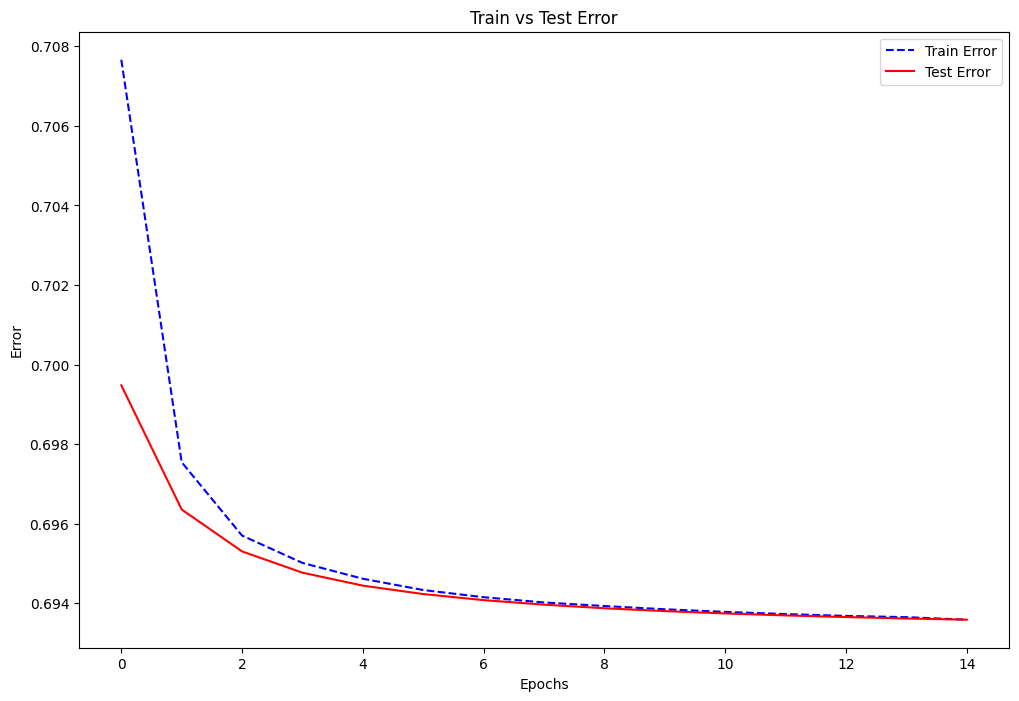


### Model Attributes:
- Learning Rate: 0.02
- Input Size: 300
- Activation Function: Relu
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[951  49]
 [215 706]]
Accuracy: 0.86
Precision: 0.87
Recall: 0.86
F1 Score: 0.86




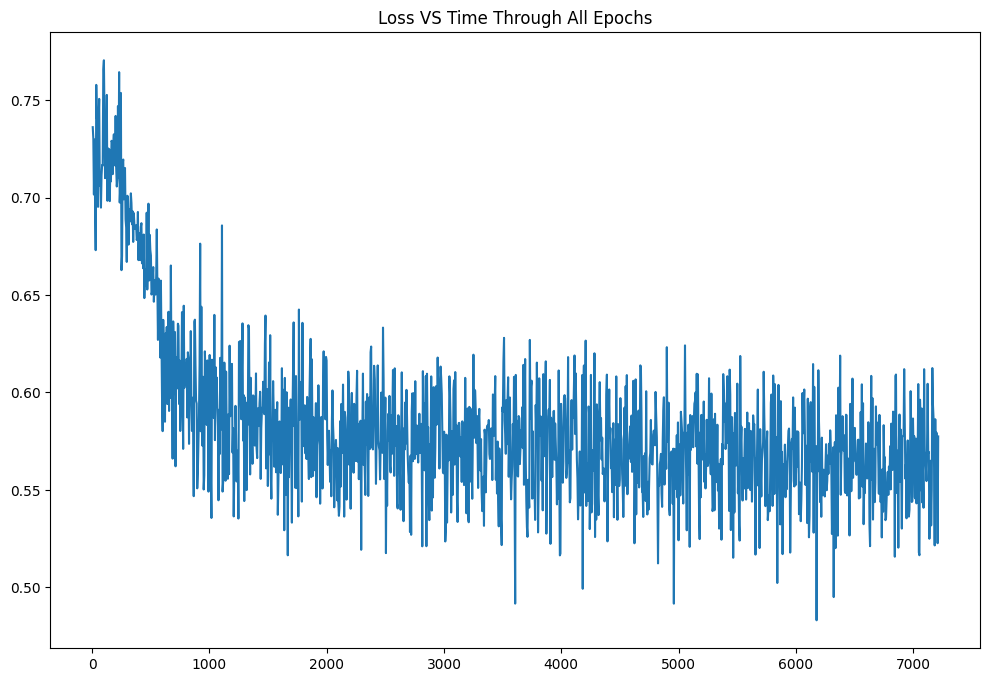

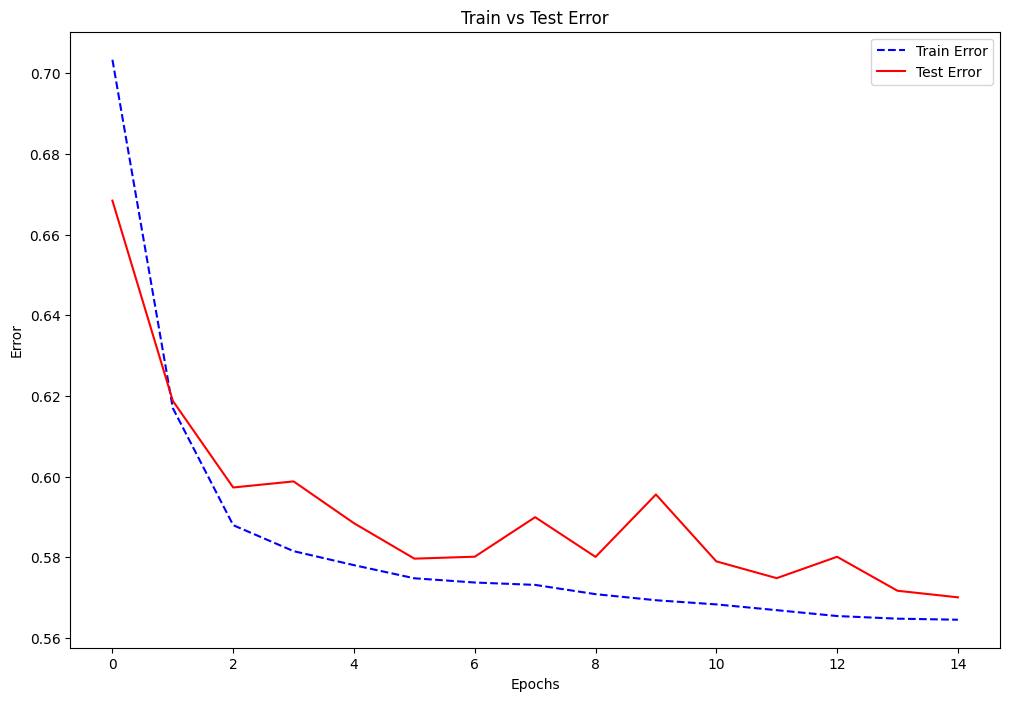


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 300
- Activation Function: Sigmoid
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[1000    0]
 [ 921    0]]
Accuracy: 0.52
Precision: 0.27
Recall: 0.52
F1 Score: 0.36




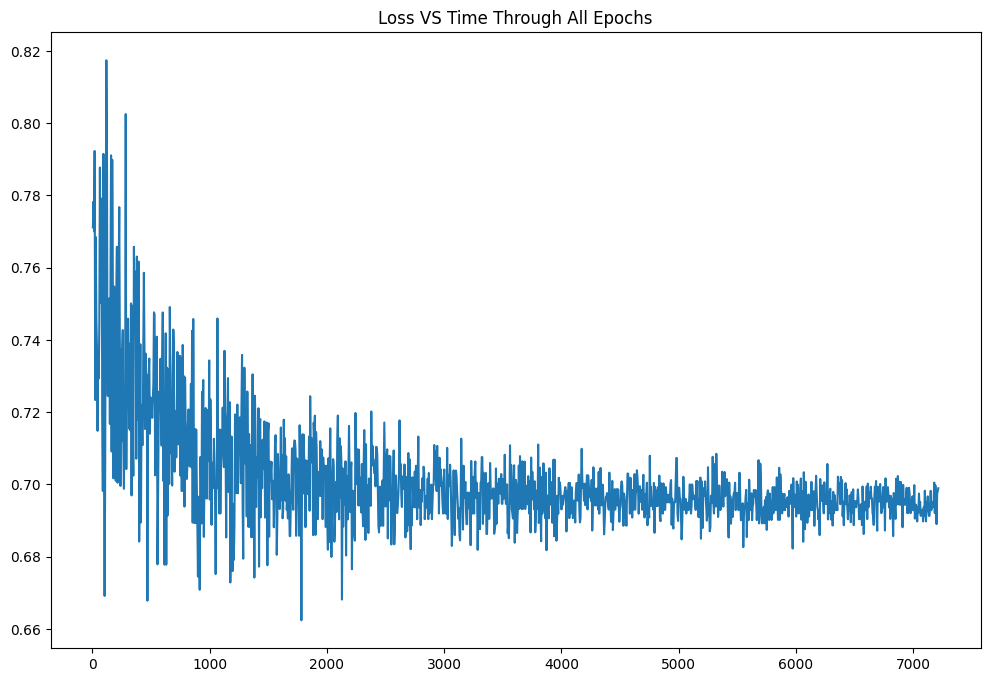

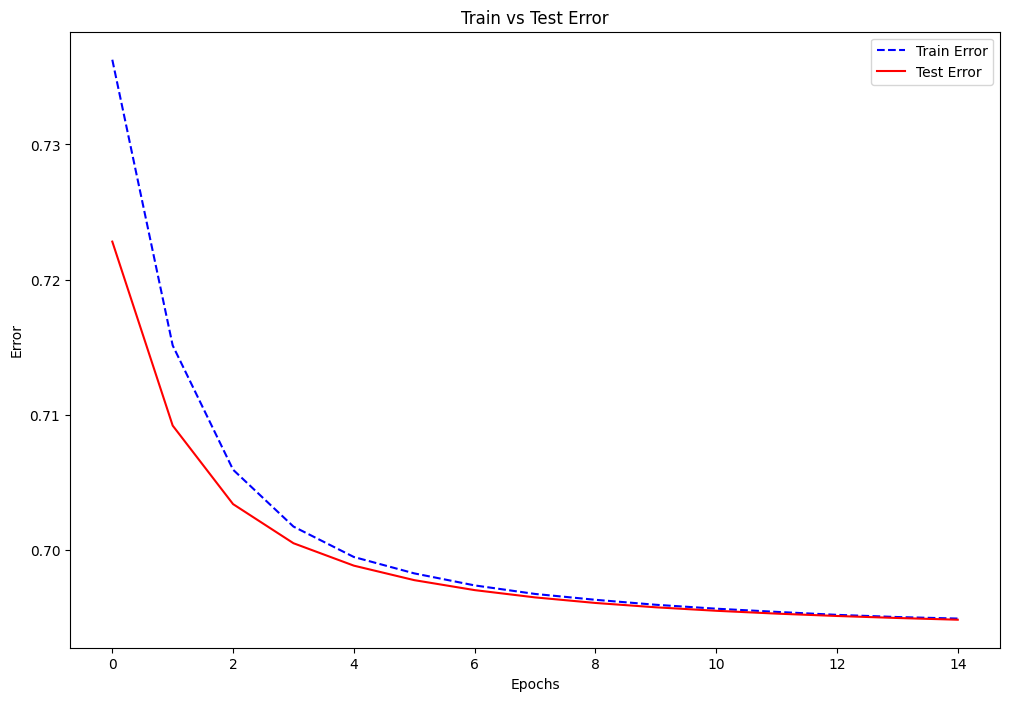


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 300
- Activation Function: Relu
- Batch Size: 16
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[950  50]
 [285 636]]
Accuracy: 0.83
Precision: 0.84
Recall: 0.83
F1 Score: 0.82




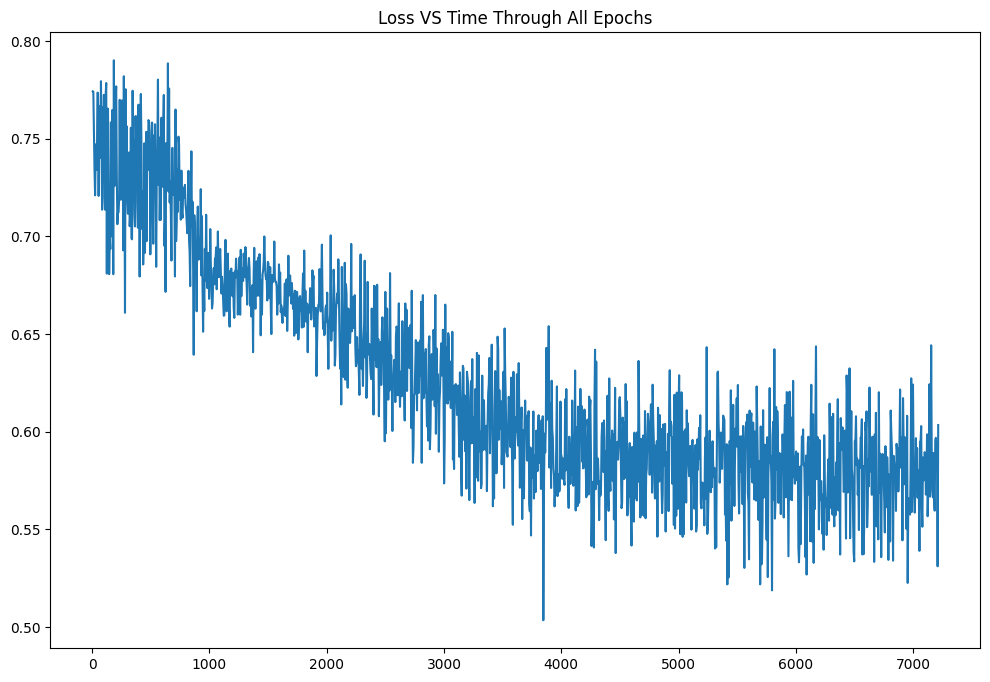

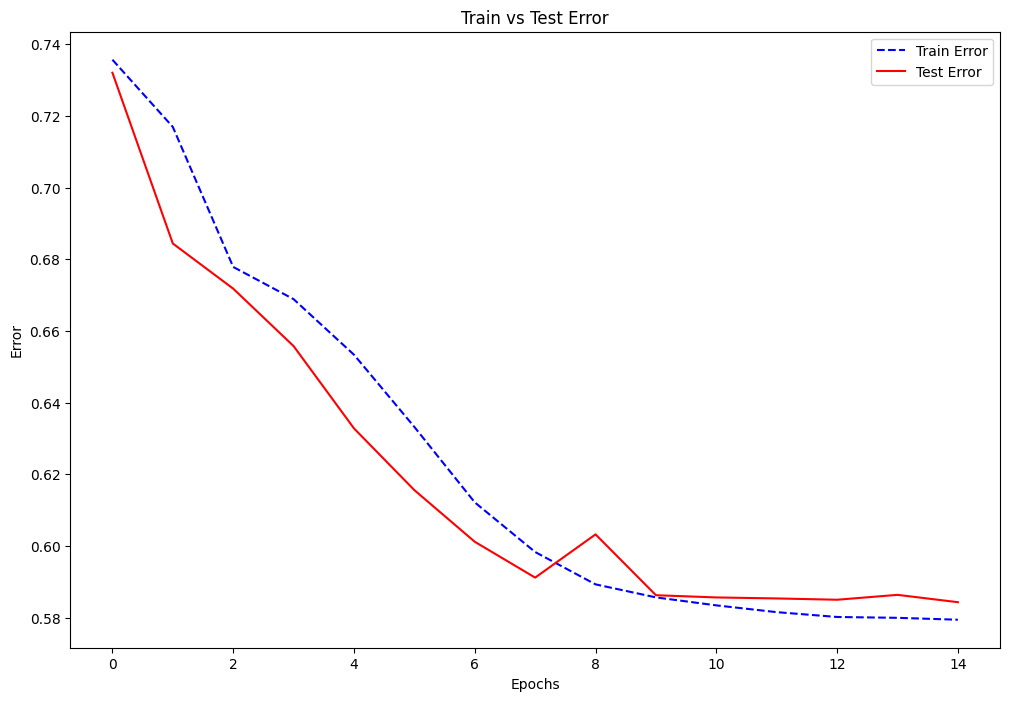


### Model Attributes:
- Learning Rate: 0.02
- Input Size: 300
- Activation Function: Sigmoid
- Batch Size: 32
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[1000    0]
 [ 921    0]]
Accuracy: 0.52
Precision: 0.27
Recall: 0.52
F1 Score: 0.36




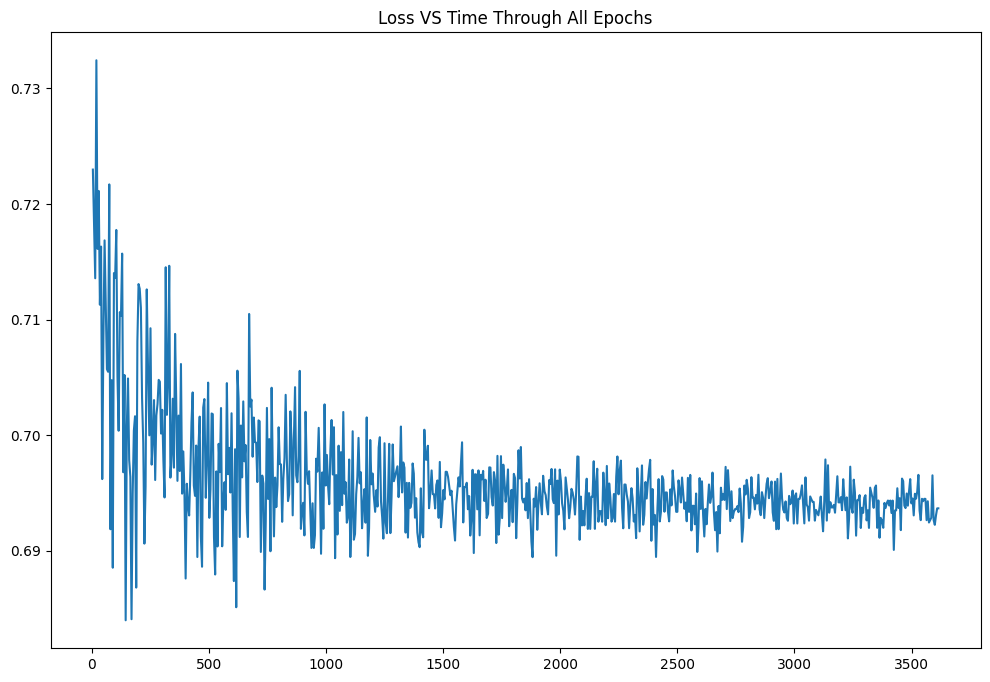

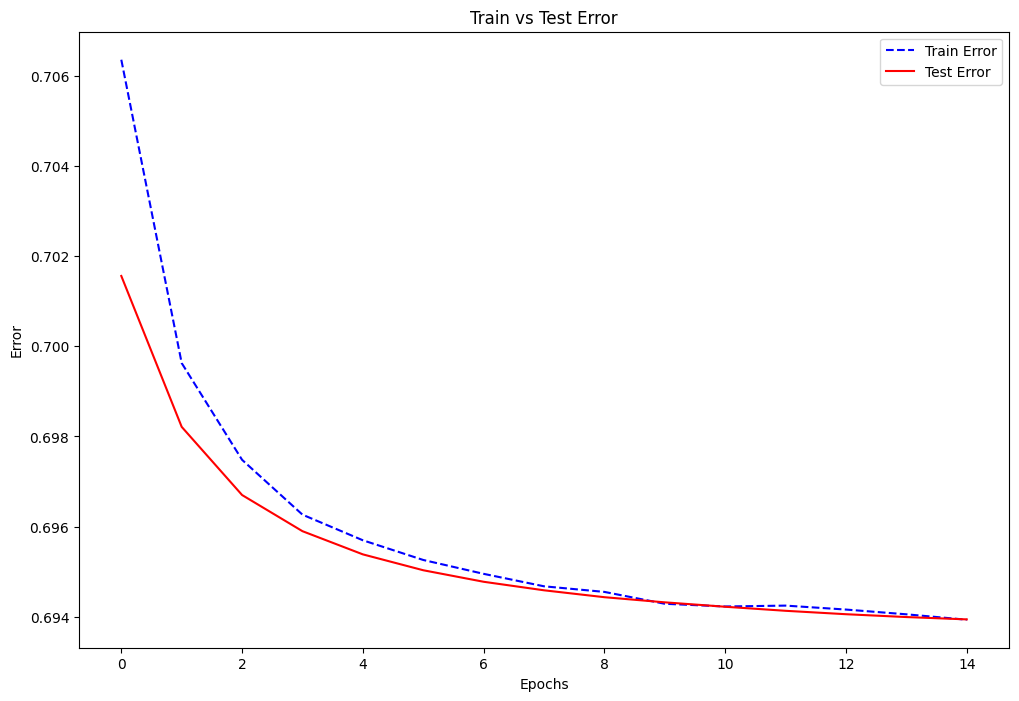


### Model Attributes:
- Learning Rate: 0.02
- Input Size: 300
- Activation Function: Relu
- Batch Size: 32
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[890 110]
 [177 744]]
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85




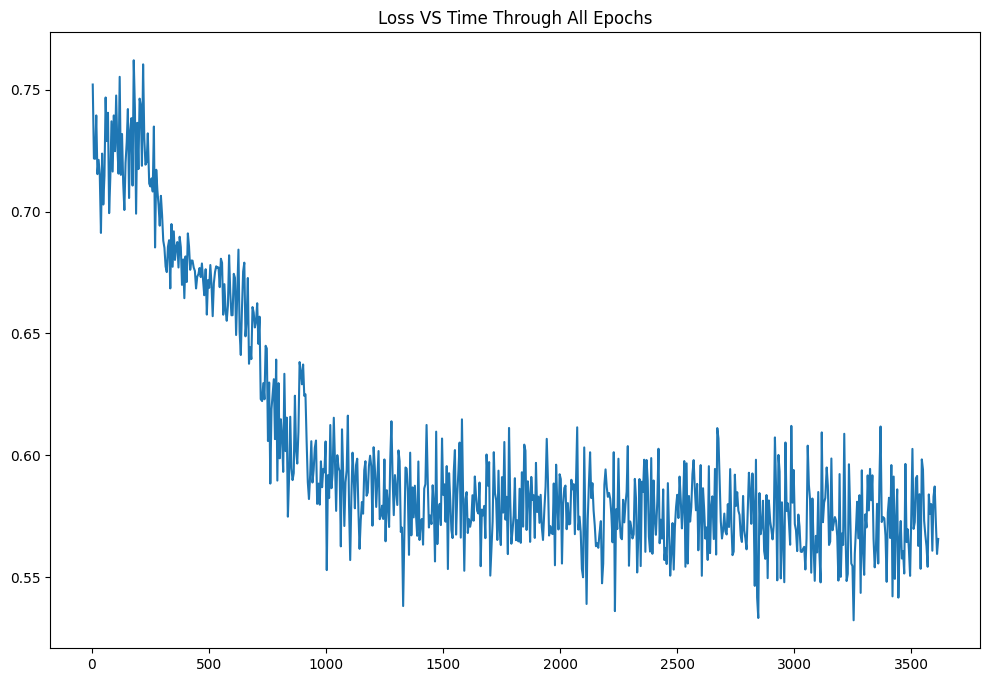

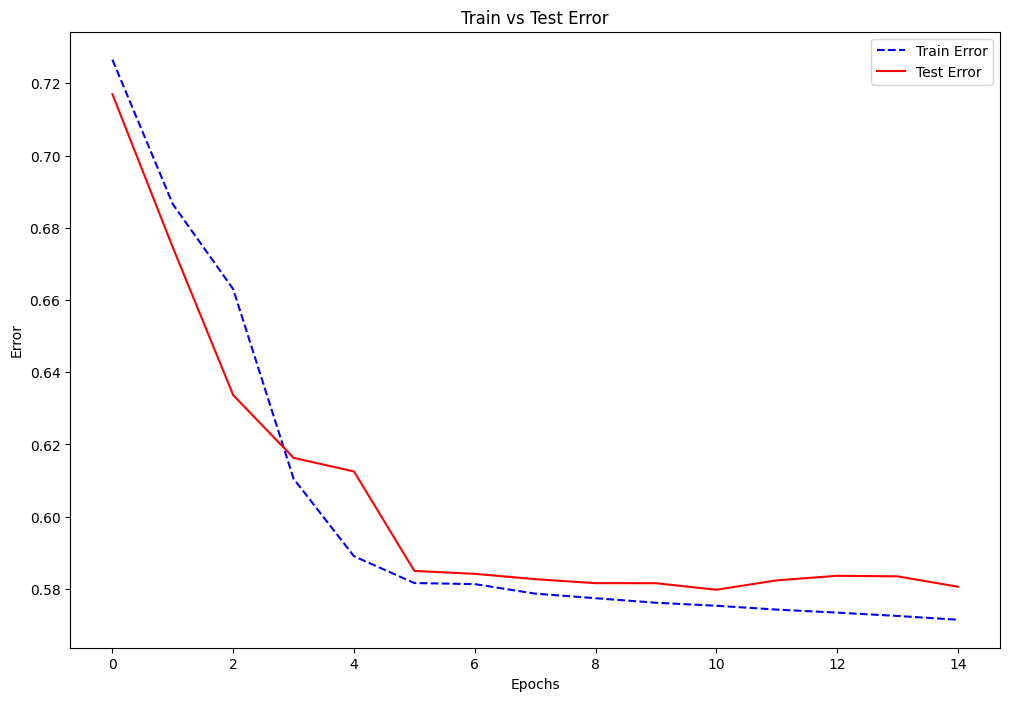


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 300
- Activation Function: Sigmoid
- Batch Size: 32
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[1000    0]
 [ 921    0]]
Accuracy: 0.52
Precision: 0.27
Recall: 0.52
F1 Score: 0.36




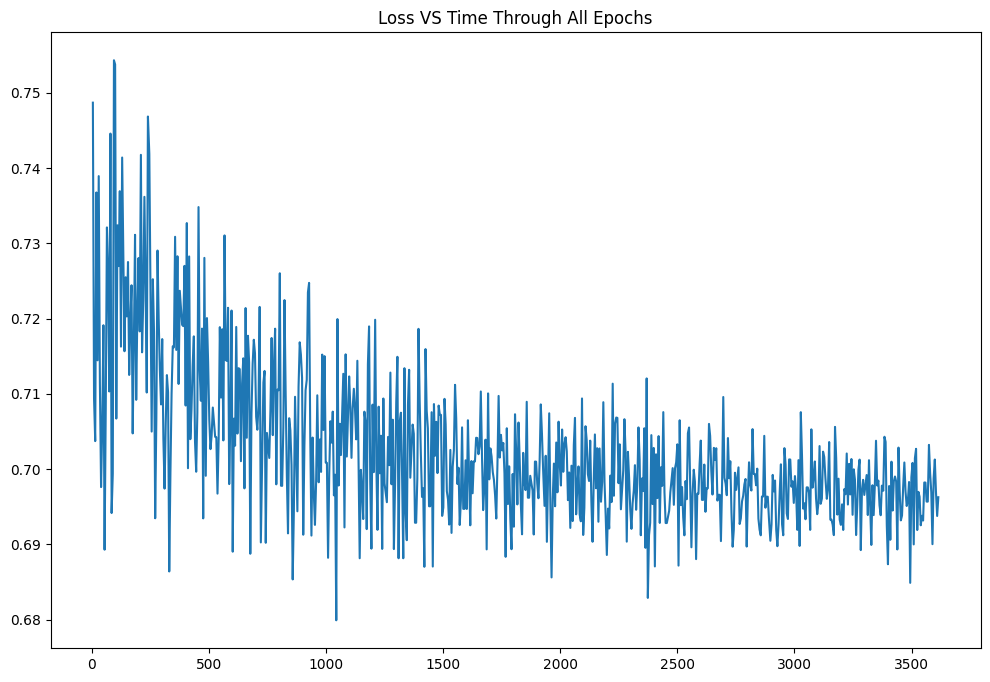

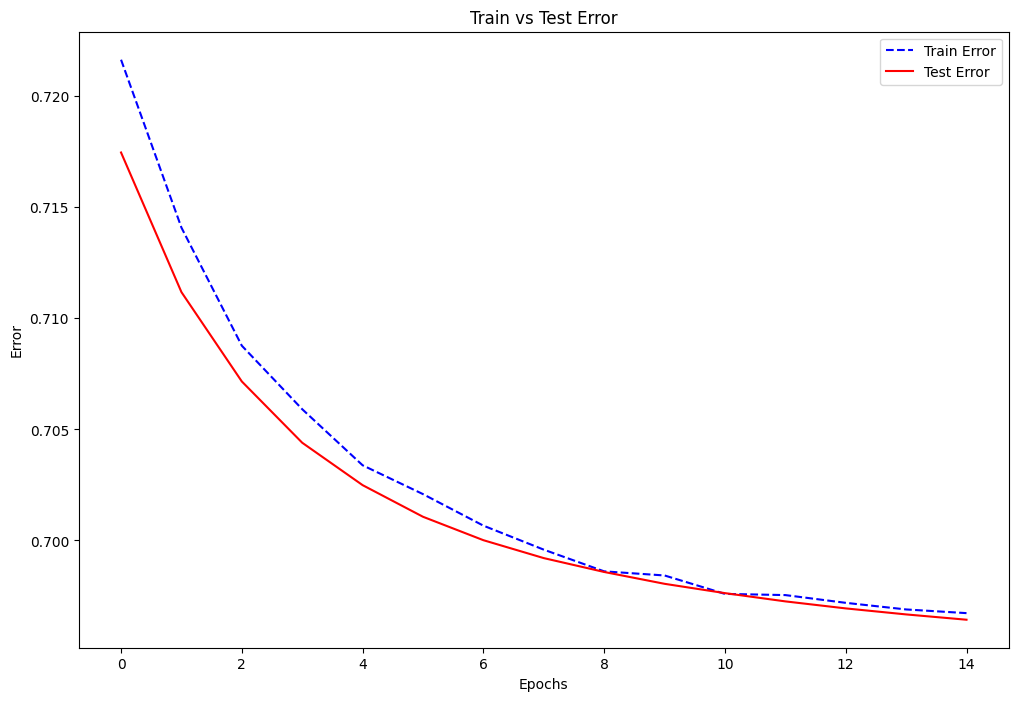


### Model Attributes:
- Learning Rate: 0.005
- Input Size: 300
- Activation Function: Relu
- Batch Size: 32
                

Training..
█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄█▄
Finished Training


### Results: 

Confusion Matrix:
[[945  55]
 [293 628]]
Accuracy: 0.82
Precision: 0.84
Recall: 0.82
F1 Score: 0.82




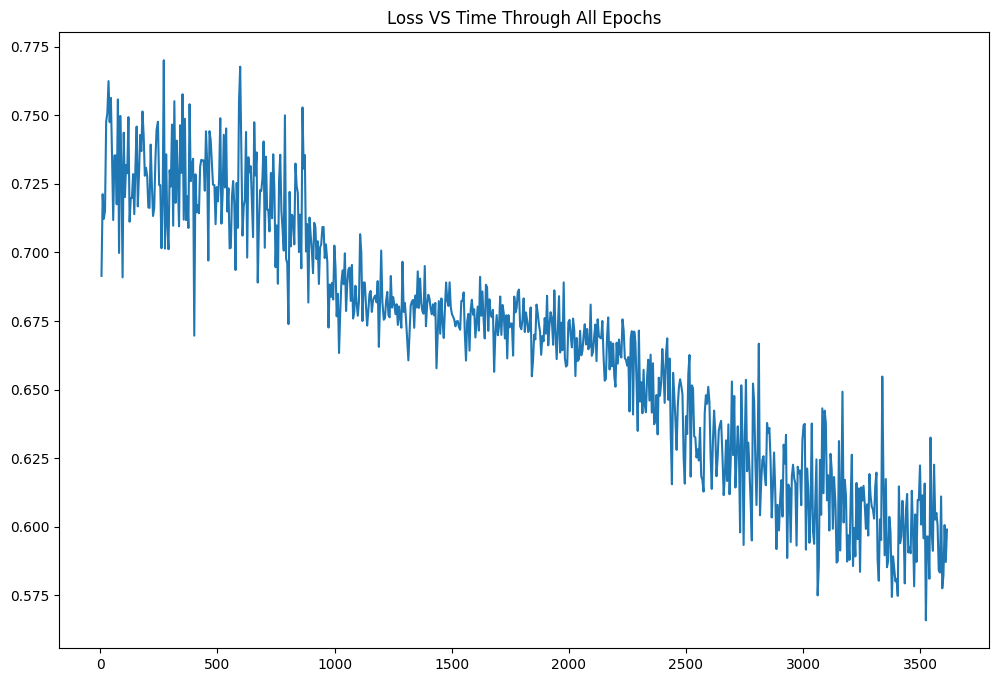

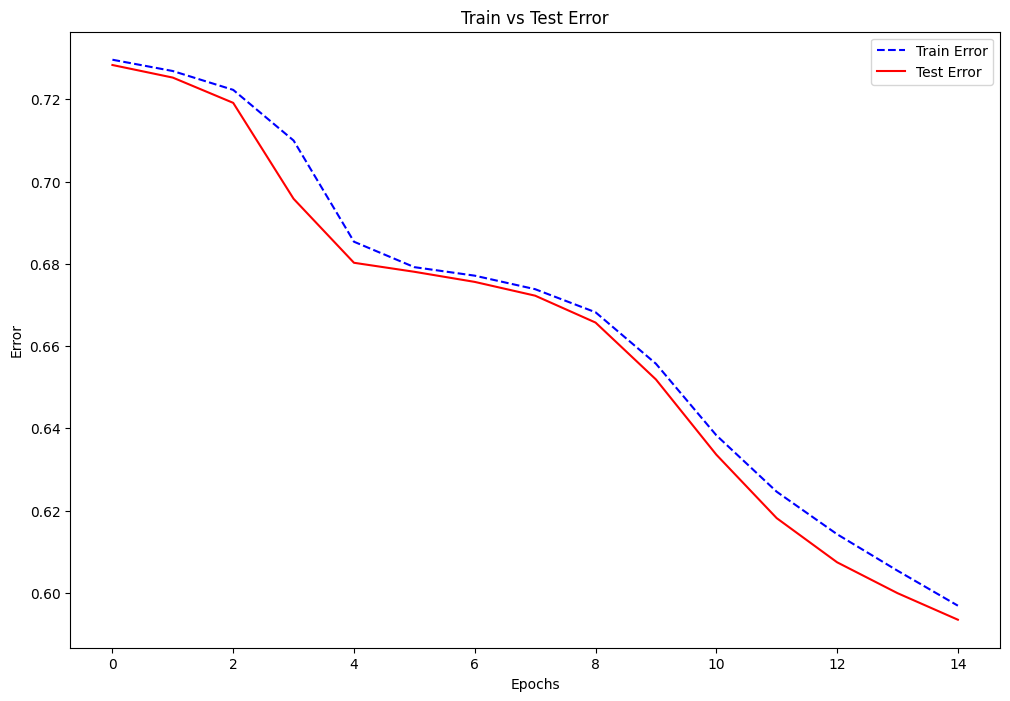

In [13]:
text = """
## Modeling
"""
display(Markdown(text))

inputSize = 300
epoch_num = 15
i = -1

CNNModels_ = []

for batch_size in [16, 32]:
    for lr in [0.02, 0.005]:
        for activation in ["Sigmoid", "Relu"]:
            text = f"""
### Model Attributes:
- Learning Rate: {lr}
- Input Size: {inputSize}
- Activation Function: {activation}
- Batch Size: {batch_size}
                """
            display(Markdown(text))

            model = CNN(activation).to(dml)

            transform = transformer

            metrics = train(model, lr, batch_size, transform, epoch_num)

            text = """### Results: """
            display(Markdown(text))

            finalMetrics = testModel(model, False, transform)
            plotTrainError(metrics[0], metrics[1])
            print()
            plotTrainTestError(epoch_num, metrics[2], metrics[3])

            i += 1
            torch.save(model.state_dict(), f"CNNModels/model{i}.pth")

            modelDetails = ["CNN", batch_size, inputSize, lr, activation]
            modelDetails.extend(finalMetrics)
            CNNModels_.append(modelDetails)

In [30]:
columns = ["Model","Batch Size", "Input Size", "Learning Rate", "Activation Function", "Accuracy", "Precision", "Recall", "F1Svore"]
df = pd.DataFrame(CNNModels_, columns=columns)
df

,Model,Batch Size,Input Size,Learning Rate,Activation Function,Accuracy,Precision,Recall,F1Svore
0,CNN,16,300,0.020,Sigmoid,0.521,0.271,0.521,0.356
1,CNN,16,300,0.020,Relu,0.863,0.873,0.863,0.861
2,CNN,16,300,0.005,Sigmoid,0.521,0.271,0.521,0.356
3,CNN,16,300,0.005,Relu,0.826,0.845,0.826,0.822
4,CNN,32,300,0.020,Sigmoid,0.521,0.271,0.521,0.356
5,CNN,32,300,0.020,Relu,0.851,0.852,0.851,0.850
6,CNN,32,300,0.005,Sigmoid,0.521,0.271,0.521,0.356
7,CNN,32,300,0.005,Relu,0.819,0.838,0.819,0.815


Again, we can see all our experiments results and plots above, and we can make comparisons of 4v4 models for each feature we are testing

#### Activation Functions

All our sigmoid-run functions turned out to die after a couple of epochs. This is again due to vanishing gradient, being more probable here with a bigger network. So using sigmoid for big neural networks without applying normalziation techniques can be a bad idea.

#### Batch Size

We can see a slightly better result for the lower batch size, this could be happenning because of the effect that increasing the batch size have on the strength of gradients calculations. The higher the size, the less effect each batch has on the model. However, different results couldve had been obtained if training was done with higher epochs. Sadly this already took a long time computing so I couldn't do more ):

#### Learning Rate

We can see a similar pattern here, with 0.02 learning rates having better results since the models are still not overfitting, and 0.02 isnt that big of a value that causes high oscilations and ruins the models learning. However, in our training/testing plots we can see that 0.005 models have a smoother curve than those of 0.02, and they will probably superpass 0.02 models with more epochs

## Comparing CNNs and MLPs

If we compare metrics of the best model of each category we find that:

|  | CNN | MLP |
|----------|----------|----------|
| Accuracy  | 0.863  | 0.906  |
| F1  | 0.861  | 0.906  |
| Number of Parameters  | 83017 | 968449/34568449  |
| Model No.  | 1 | 5  |

(Number of Params for MLP is decided by input size)

We found out that with equal number of epochs MLP performance passed that of CNN. Nonetheless, we can see from test/train loss graphs drawn above that CNNs generally have more capacity for improvement with more iterations without overfitting. While many MLPs are starting to overfit with no to low reduction in test error with more iterations. So we can expect that with more iterations and more parameters in CNNs, the CNN models will surpass MLP models. Another interesting fact is that all sigmoid activated CNNs are dead after a couple of iterations while we can see some that are not bad in MLPs. This is probably due to CNNs being a deeper network with more layers into it. In addition to that, number of parameters in MLP is much bigger compared to CNNs due to CNNs shrinking the image before getting into fully connected layers, which gives more room for more complex models while extracting necessary features from the image